**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**author**: Rohan Bhapkar

**date**: 1st March, 2024

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a> 
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>
    - <a href='#build'>4.2. Model Building</a>
    - <a href='#perf'>4.3. Model Performance</a>
- <a href='#concl'>5. Conclusions</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~96% |
| Test Set* | ~95% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Br35H :: Brain Tumor Detection 2020](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection/data). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [1]:
# Importing necessary libraries
import numpy as np 
from tqdm import tqdm  # For progress bars
import cv2  # OpenCV for image processing
import os  # For file and directory operations
import shutil  # For file operations
import itertools  # For iterating over data
import imutils  # For image manipulation
import matplotlib.pyplot as plt  # For plotting
from warnings import filterwarnings  # For suppressing warnings

# Machine learning libraries
from sklearn.preprocessing import LabelBinarizer  # For label binarization
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.metrics import accuracy_score, confusion_matrix  # For evaluation metrics

# Plotly for interactive visualization
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# Tensorflow and Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image data preprocessing
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # VGG16 model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input  # Layers for model construction
from tensorflow.keras.models import Model, Sequential  # Model architecture
from tensorflow.keras.optimizers import Adam, RMSprop  # Optimizers for model training
from tensorflow.keras.callbacks import EarlyStopping  # Callback for early stopping

# Initializing Plotly for notebook mode
init_notebook_mode(connected=True)

# Setting a random seed for reproducibility
RANDOM_SEED = 123

# Suppressing warnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)


Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [2]:
import splitfolders  # Library for splitting dataset into train, validation, and test sets

# Define input and output paths
input_folder = 'brain_tumor_dataset/'  # Path to the original dataset
output_folder = 'split_data/'  # Path to the folder where split dataset will be saved

# Split the dataset with a ratio of 80% for training, 10% for validation, and 10% for testing
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 3000 files [00:11, 251.71 files/s]


# <a id='import'>3. Data Import and Preprocessing</a>

In [3]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    
    Parameters:
    dir_path (str): Path to the directory containing image folders.
    img_size (tuple): Size to which images will be resized. Default is (100, 100).
    
    Returns:
    tuple: A tuple containing X (image data), y (labels), and labels (dictionary of label indices).
    """
    X = []  # List to store image data
    y = []  # List to store labels
    i = 0  # Counter for label indices
    labels = dict()  # Dictionary to map label indices to label names
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)  # Read image
                    #img = cv2.resize(img, img_size)  # Resize image (if required)
                    X.append(img)  # Append image to X
                    y.append(i)  # Append label index to y
            i += 1
    X = np.array(X)  # Convert X to numpy array
    y = np.array(y)  # Convert y to numpy array
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Parameters:
    cm (numpy.ndarray): Confusion matrix.
    classes (list): List of class names.
    normalize (bool): Flag to normalize confusion matrix. Default is False.
    title (str): Title of the plot. Default is 'Confusion matrix'.
    cmap (matplotlib.colors.Colormap): Colormap for the plot. Default is plt.cm.Blues.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


define the paths to the directories containing training, test, and validation images. Then, you load the image data using the `load_data()` function you defined earlier, passing in the directory paths and image size. Finally, the loaded data is stored in variables `X_train`, `y_train`, `X_test`, `y_test`, `X_val`, and `y_val`. 

In [4]:
TRAIN_DIR = 'split_data/train/'  # Directory containing training images
TEST_DIR = 'split_data/test/'    # Directory containing test images
VAL_DIR = 'split_data/val/'      # Directory containing validation images
IMG_SIZE = (224,224)             # Image size to be used

# Load training data
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)

# Load test data
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)

# Load validation data
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.06s/it]


2400 images loaded from split_data/train/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


300 images loaded from split_data/test/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]

300 images loaded from split_data/val/ directory.


Let's take a look at the distribution of classes among sets:

In [5]:
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot

# Create an empty dictionary to store counts
y = dict()
y[0] = []  # Counts for class 0
y[1] = []  # Counts for class 1

# Iterate through different sets and count occurrences of each class
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))  # Count occurrences of class 0
    y[1].append(np.sum(set_name == 1))  # Count occurrences of class 1

# Create Bar traces for each class
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],  # X-axis labels
    y=y[0],  # Counts for class 0
    name='No',  # Legend label for class 0
    marker=dict(color='#ff3300'),  # Set color for class 0
    opacity=0.7  # Set opacity for class 0 bars
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],  # X-axis labels
    y=y[1],  # Counts for class 1
    name='Yes',  # Legend label for class 1
    marker=dict(color='#33cc33'),  # Set color for class 1
    opacity=0.7  # Set opacity for class 1 bars
)

# Combine traces into data
data = [trace0, trace1]

# Set layout for the plot
layout = go.Layout(
    title='Count of classes in each set',  # Title of the plot
    xaxis={'title': 'Set'},  # X-axis label
    yaxis={'title': 'Count'}  # Y-axis label
)

# Create figure
fig = go.Figure(data, layout)

# Plot the figure
iplot(fig)  # Plot the figure using Plotly's interactive plotting


In [6]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    
    Parameters:
    X (numpy.ndarray): Array of images.
    y (numpy.ndarray): Array of labels.
    labels_dict (dict): Dictionary mapping label indices to label names.
    n (int): Number of images to plot for each class. Default is 50.
    """
    for index in range(len(labels_dict)):  # Iterate over each class
        imgs = X[np.argwhere(y == index)][:n]  # Get n images for the current class
        j = 10  # Number of columns in the gridplot
        i = int(n/j)  # Number of rows in the gridplot

        plt.figure(figsize=(15,6))  # Set the figure size
        c = 1  # Counter for subplot index
        for img in imgs:
            plt.subplot(i,j,c)  # Create subplot
            plt.imshow(img[0])  # Display the image

            plt.xticks([])  # Remove x-axis ticks
            plt.yticks([])  # Remove y-axis ticks
            c += 1  # Increment the counter for subplot index
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))  # Add title to the plot
        
        plt.show()  # Show the plot


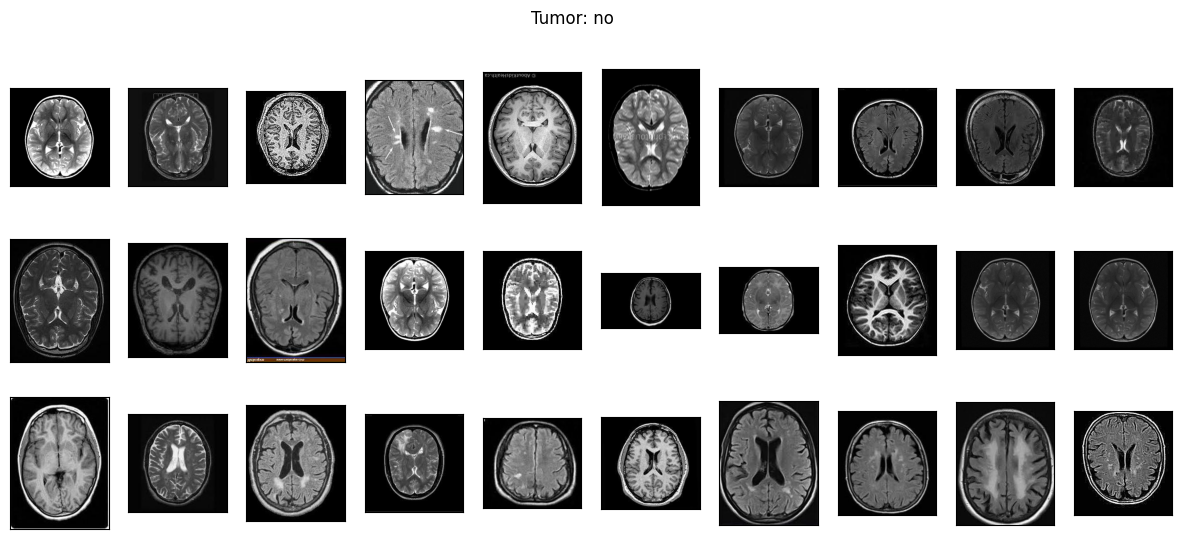

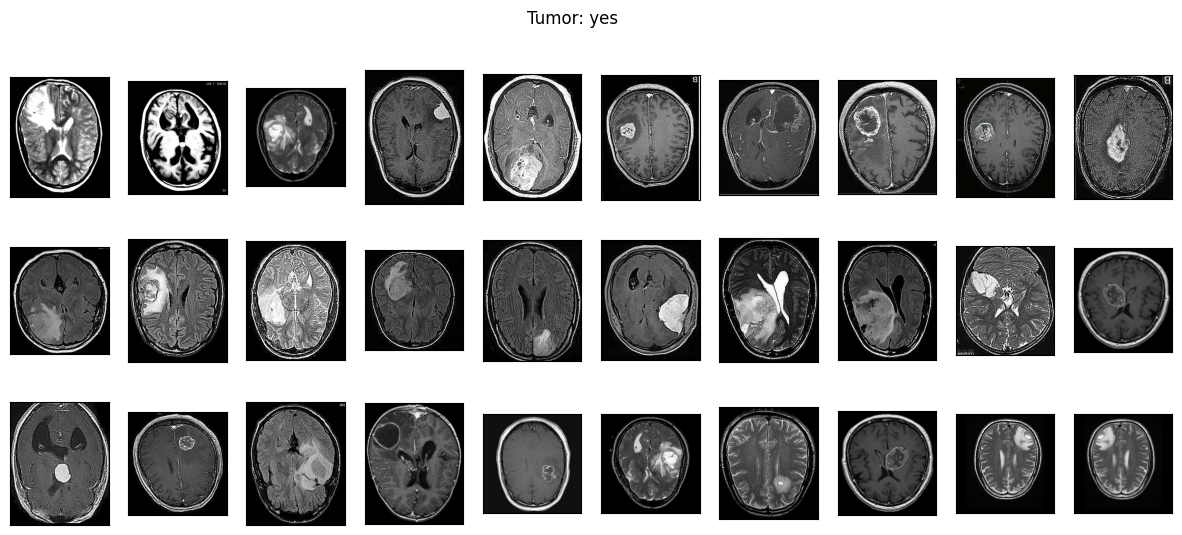

In [7]:
# Plot the no and yes class images
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

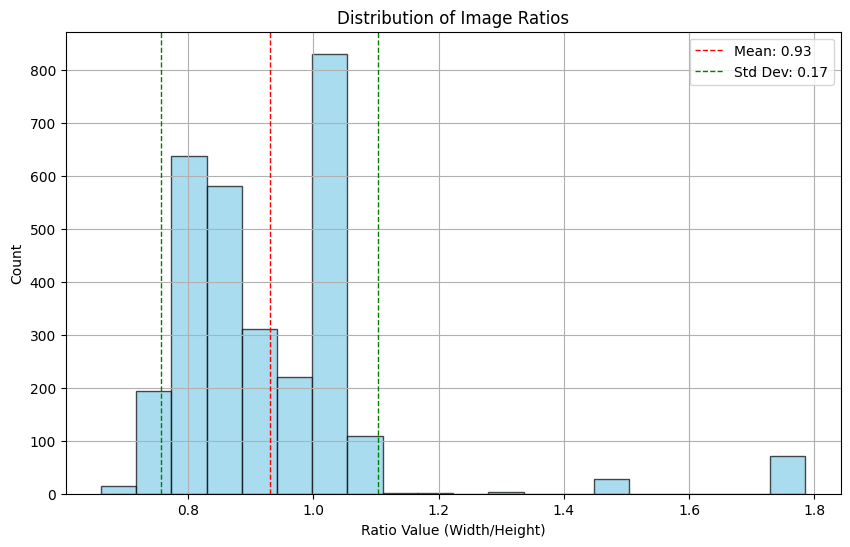

In [8]:
# Initialize an empty list to store image ratios
RATIO_LIST = []

# Calculate image ratios for each set
for dataset in (X_train, X_test, X_val):
    for img in dataset:
        # Append the ratio of image width to height
        ratio = img.shape[1] / img.shape[0]
        RATIO_LIST.append(ratio)

# Plot histogram
plt.figure(figsize=(10, 6))  # Set figure size for better visualization
plt.hist(RATIO_LIST, bins=20, color='skyblue', edgecolor='black', alpha=0.7)  # Plot histogram
plt.title('Distribution of Image Ratios')  # Set title of the plot
plt.xlabel('Ratio Value (Width/Height)')  # Set label for x-axis
plt.ylabel('Count')  # Set label for y-axis
plt.grid(True)  # Enable grid

# Add mean and standard deviation lines to the plot
mean_ratio = np.mean(RATIO_LIST)  # Calculate mean ratio
std_ratio = np.std(RATIO_LIST)  # Calculate standard deviation of ratios
plt.axvline(mean_ratio, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_ratio:.2f}')  # Add mean line
plt.axvline(mean_ratio + std_ratio, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std_ratio:.2f}')  # Add upper std dev line
plt.axvline(mean_ratio - std_ratio, color='green', linestyle='dashed', linewidth=1)  # Add lower std dev line

# Add legend
plt.legend()

# Save the figure as a PNG file
plt.savefig("assets/Distribution_of_Image_Ratios.png")

# Show the plot
plt.show()


The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [9]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    
    Parameters:
    set_name (numpy.ndarray): Array of images.
    add_pixels_value (int): Number of pixels to add around the cropped area. Default is 0.
    
    Returns:
    numpy.ndarray: Array of cropped images.
    """
    set_new = []  # List to store cropped images
    for img in set_name:  # Iterate through each image in the set
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply Gaussian blur
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        
        # Perform erosion and dilation to remove noise
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in the thresholded image
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        # Find the largest contour (assumed to be the object of interest)
        if cnts:
            c = max(cnts, key=cv2.contourArea)

            # Find extreme points of the contour
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])

            # Adjust cropping area by adding pixels
            ADD_PIXELS = add_pixels_value
            cropped_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
            
            set_new.append(cropped_img)  # Append cropped image to the list

    return np.array(set_new)  # Return cropped images as numpy array


Let's look at example what this function will do with MRI scans:

In [10]:
# Load the image
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')

# Resize the image
img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold the image to create a binary image
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

# Perform morphological operations (erosion and dilation) to remove noise
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# Find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Find the largest contour
c = max(cnts, key=cv2.contourArea)

# Find the extreme points of the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# Draw the contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# Draw the extreme points on the image
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# Add some pixels to create a margin and crop the region of interest
ADD_PIXELS = 0  # Adjust the number of pixels to add if needed
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


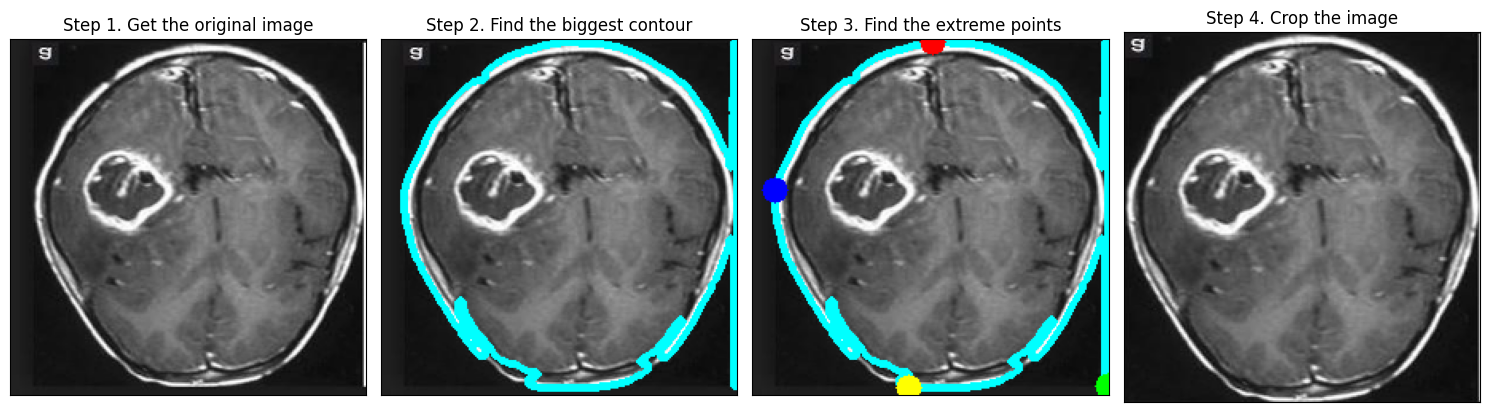

In [11]:
# Create a figure with 4 subplots
plt.figure(figsize=(15, 6))

# Subplot 1: Original image
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')

# Subplot 2: Image with the biggest contour
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')

# Subplot 3: Image with extreme points
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')

# Subplot 4: Cropped image
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig("assets/image_processing_steps.png")

# Show the plot
plt.show()


In [12]:
# Apply crop_imgs function to training set
X_train_crop = crop_imgs(set_name=X_train)

# Apply crop_imgs function to validation set
X_val_crop = crop_imgs(set_name=X_val)

# Apply crop_imgs function to test set
X_test_crop = crop_imgs(set_name=X_test)


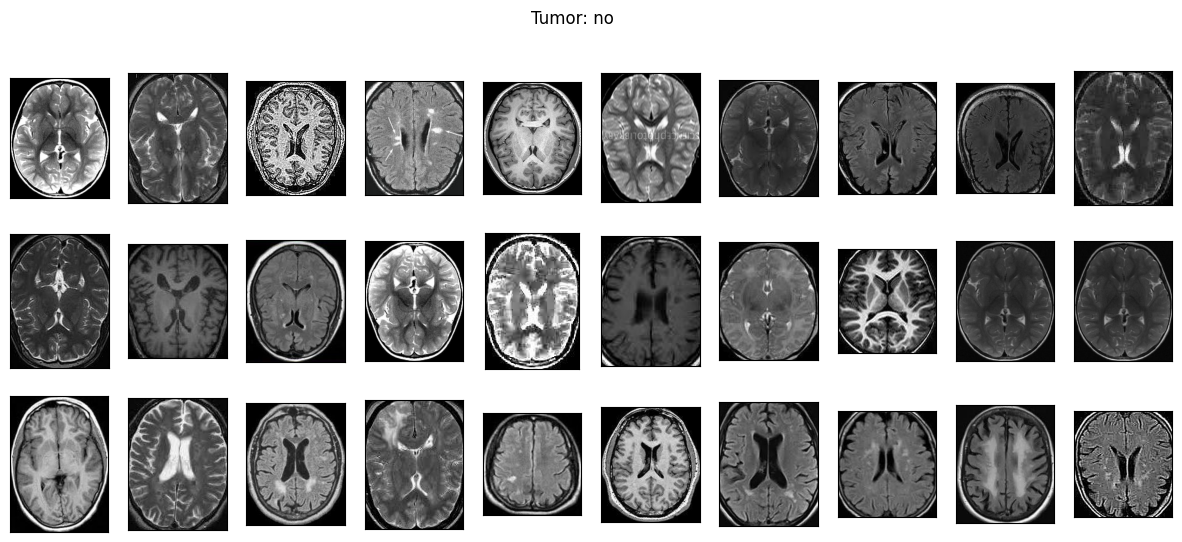

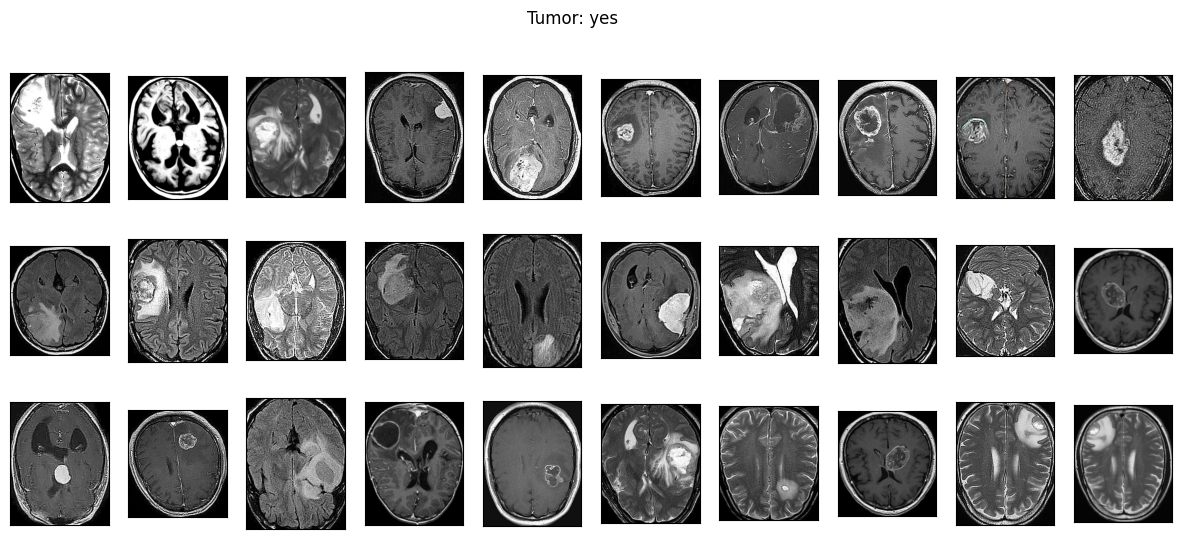

In [13]:
plot_samples(X_train_crop, y_train, labels, 30)

In [14]:
def save_new_images(x_set, y_set, folder_name):
    """
    Save images to disk based on their class labels

    Args:
    - x_set: List or array of images
    - y_set: List or array of class labels
    - folder_name: Name of the folder where images will be saved
    """
    # Create directories if they don't exist
    os.makedirs(os.path.join(folder_name, 'no'), exist_ok=True)  # Create 'no' class folder
    os.makedirs(os.path.join(folder_name, 'yes'), exist_ok=True)  # Create 'yes' class folder
    
    # Iterate over images and their class labels
    for i, (img, imclass) in enumerate(zip(x_set, y_set)):
        # Determine class folder based on class label
        class_folder = 'no' if imclass == 0 else 'yes'
        # Save the image to the corresponding class folder
        cv2.imwrite(os.path.join(folder_name, class_folder, f'{i}.jpg'), img)


In [15]:
# Saving new images to the folder
save_new_images(X_train_crop, y_train, folder_name='crop_data/train_crop/')
save_new_images(X_val_crop, y_val, folder_name='crop_data/val_crop/')
save_new_images(X_test_crop, y_test, folder_name='crop_data/test_crop/')


The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [16]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing to a set of images.

    Args:
    - set_name: List or array of images to be preprocessed.
    - img_size: Tuple specifying the desired size (width, height) for the resized images.

    Returns:
    - np.array: Array of preprocessed images.
    """
    set_new = []  # List to store preprocessed images
    
    # Iterate over each image in the set
    for img in set_name:
        # Resize the image
        img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
        # Apply VGG-16 preprocessing
        img = preprocess_input(img)
        # Append the preprocessed image to the new set
        set_new.append(img)
    
    # Convert the list of preprocessed images to a numpy array
    return np.array(set_new)


In [17]:
# Preprocess training set
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)

# Preprocess test set
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)

# Preprocess validation set
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [18]:
# Define an ImageDataGenerator for augmentation
demo_datagen = ImageDataGenerator(
    rotation_range=15,              # Degree range for random rotations
    width_shift_range=0.05,         # Fraction of total width for random horizontal shifts
    height_shift_range=0.05,        # Fraction of total height for random vertical shifts
    rescale=1./255,                 # Rescaling factor
    shear_range=0.05,               # Shear intensity (shear angle in counter-clockwise direction)
    brightness_range=[0.1, 1.5],    # Range for random brightness augmentation
    horizontal_flip=True,           # Randomly flip inputs horizontally
    vertical_flip=True              # Randomly flip inputs vertically
)

In [19]:
# Remove the 'preview' directory and its contents if it exists
shutil.rmtree('preview', ignore_errors=True)

# Define the directory to save augmented images
os.makedirs('preview', exist_ok=True)

# Take an example image from X_train_crop for augmentation
x = X_train_crop[0]  

# Reshape the image to (1, height, width, channels) to fit the flow method of ImageDataGenerator
x = x.reshape((1,) + x.shape) 

# Generate and save augmented images
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break


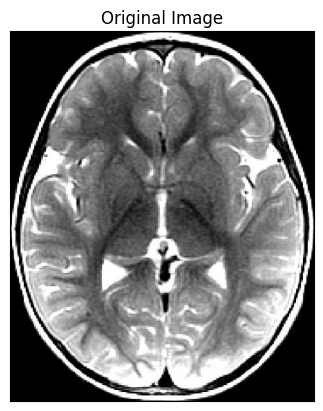

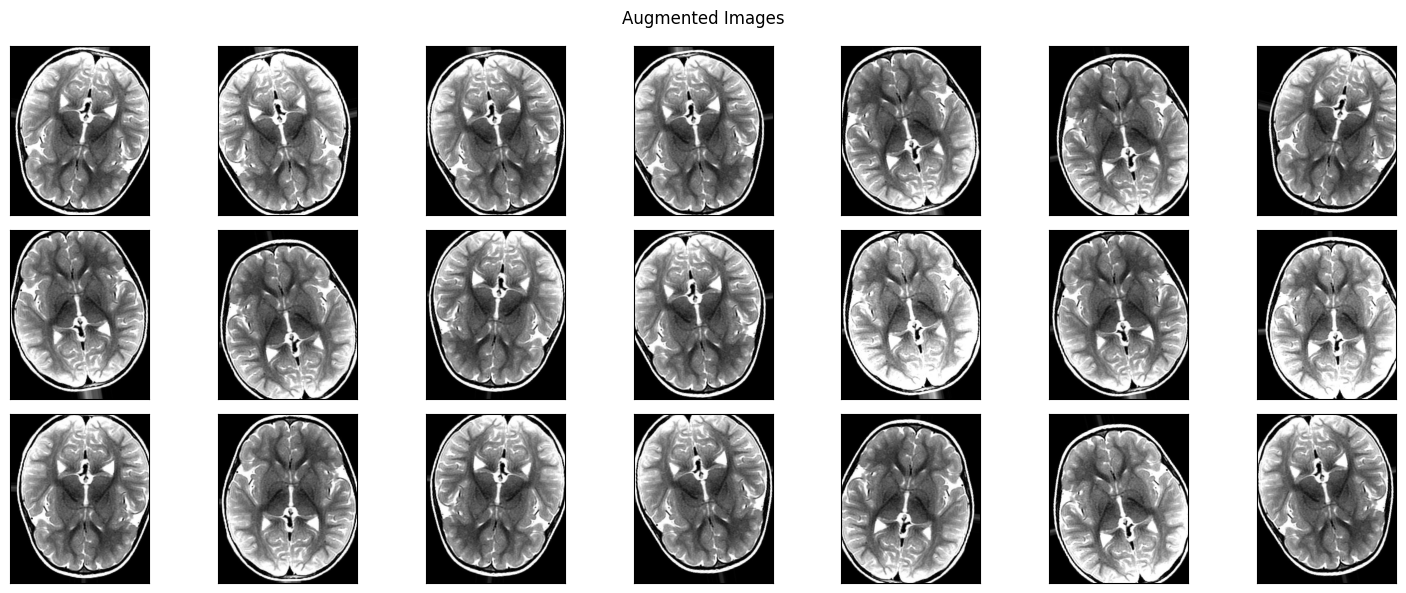

In [20]:
# Display the original image
plt.imshow(X_train_crop[0])  # Display the first cropped image from the training set
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.title('Original Image')  # Set title for the plot
plt.show()  # Show the plot

# Display augmented images
plt.figure(figsize=(15, 6))  # Set figure size
i = 1  # Initialize counter for subplot index
for img_filename in os.listdir('preview/'):  # Iterate over augmented image files in 'preview' directory
    img = cv2.imread('preview/' + img_filename)  # Read augmented image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB
    plt.subplot(3, 7, i)  # Create subplot
    plt.imshow(img)  # Display augmented image
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    i += 1  # Increment counter
    if i > 3 * 7:  # Break loop after displaying 21 augmented images
        break
plt.suptitle('Augmented Images')  # Set title for the plot
plt.tight_layout()  # Adjust layout to prevent overlap

# Save the figure as a PNG file
plt.savefig("assets/augmented_images_preview.png")

# Show the plot
plt.show()


### <a id='apply'>4.1.2. Apply</a>

In [21]:
# Define the directory paths for training and validation data
TRAIN_DIR = 'crop_data/train_crop/'
VAL_DIR = 'crop_data/val_crop/'

# Define data augmentation parameters for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,               # Degree range for random rotations
    width_shift_range=0.1,           # Fraction of total width for random horizontal shifts
    height_shift_range=0.1,          # Fraction of total height for random vertical shifts
    shear_range=0.1,                 # Shear intensity (shear angle in counter-clockwise direction)
    brightness_range=[0.5, 1.5],     # Range for random brightness augmentation
    horizontal_flip=True,            # Randomly flip inputs horizontally
    vertical_flip=True,              # Randomly flip inputs vertically
    preprocessing_function=preprocess_input  # Preprocessing function for each input image
)

# Define data augmentation parameters for validation data (no augmentation)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Preprocessing function for each input image
)

# Create data generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',                 # Color mode: 'rgb' for 3-channel color images
    target_size=IMG_SIZE,             # Target size of images after resizing
    batch_size=32,                    # Batch size for training
    class_mode='binary',              # Class mode: 'binary' for binary classification (0 or 1)
    seed=RANDOM_SEED                  # Seed for random number generator
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',                 # Color mode: 'rgb' for 3-channel color images
    target_size=IMG_SIZE,             # Target size of images after resizing
    batch_size=16,                    # Batch size for validation
    class_mode='binary',              # Class mode: 'binary' for binary classification
    seed=RANDOM_SEED                  # Seed for random number generator
)


Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [22]:
# Path to the VGG16 weights file
vgg16_weight_path = 'keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the VGG16 model with pre-trained ImageNet weights
base_model = VGG16(
    weights=vgg16_weight_path,   # Use 'imagenet' to load pre-trained weights from ImageNet
    include_top=False,           # Exclude the fully-connected layers (include only the convolutional base)
    input_shape=IMG_SIZE + (3,)  # Specify input shape according to your requirements
)

In [23]:
# Define the number of output classes
NUM_CLASSES = 1

# Create a Sequential model
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)

# Flatten the output of the VGG16 base model
model.add(Flatten())

# Add a dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Add a dense layer for binary classification
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

# Freeze the weights of the VGG16 base model
model.layers[0].trainable = False

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [24]:
# Define the number of epochs
EPOCHS = 30

# Set up EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    mode='min',          # Set mode to 'min' since we're monitoring loss
    patience=5,          # Number of epochs with no improvement before stopping
    verbose=0            # Verbosity mode (0: silent, 1: update messages)
)

In [25]:
# Compile the model with binary cross-entropy loss, RMSprop optimizer, and accuracy metric
model.compile(
    optimizer=RMSprop(learning_rate=1e-4),       # RMSprop optimizer with a learning rate of 1e-4
    loss='binary_crossentropy',                  # Binary cross-entropy loss for binary classification
    metrics=['accuracy']                         # Monitor accuracy during training
)

In [26]:
history = model.fit(
    train_generator,                       # Training data generator
    steps_per_epoch=50,                    # Number of steps (batches) per epoch
    epochs=EPOCHS,                         # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    validation_steps=10,                   # Number of steps (batches) for validation
    callbacks=[early_stopping],            # EarlyStopping callback
    verbose=1                              # Verbosity mode (0: silent, 1: update messages)
)

Epoch 1/30
50/50 [==============================] - 136s 3s/step - loss: 4.7960 - accuracy: 0.6244 - val_loss: 1.8107 - val_accuracy: 0.7188
Epoch 2/30
50/50 [==============================] - 116s 2s/step - loss: 3.1579 - accuracy: 0.7006 - val_loss: 0.9879 - val_accuracy: 0.8250
Epoch 3/30
50/50 [==============================] - 114s 2s/step - loss: 2.6701 - accuracy: 0.7425 - val_loss: 1.8337 - val_accuracy: 0.7750
Epoch 4/30
50/50 [==============================] - 117s 2s/step - loss: 2.2507 - accuracy: 0.7781 - val_loss: 0.8121 - val_accuracy: 0.9062
Epoch 5/30
50/50 [==============================] - 114s 2s/step - loss: 2.0295 - accuracy: 0.7862 - val_loss: 0.8432 - val_accuracy: 0.8750
Epoch 6/30
50/50 [==============================] - 114s 2s/step - loss: 1.8447 - accuracy: 0.8037 - val_loss: 0.7335 - val_accuracy: 0.8813
Epoch 7/30
50/50 [==============================] - 116s 2s/step - loss: 1.8756 - accuracy: 0.8181 - val_loss: 0.4688 - val_accuracy: 0.9438
Epoch 8/30
50

## <a id='perf'>4.3. Model Performance</a>

75/75 [==============================] - 149s 2s/step
Train Accuracy = 0.96


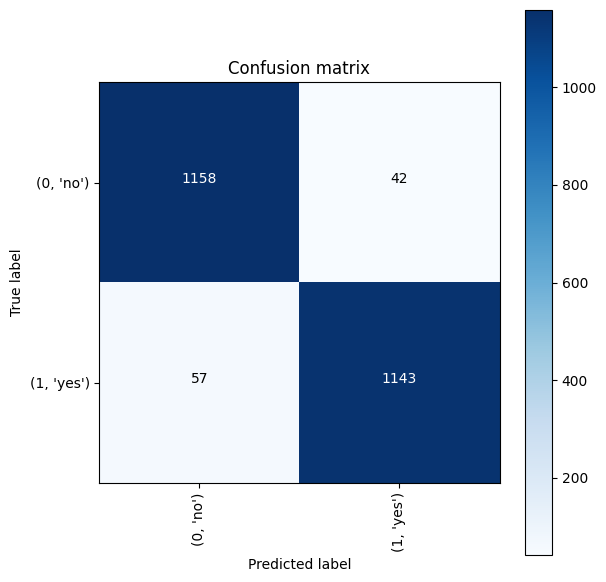

In [27]:
# Validate on train set
predictions_train = model.predict(X_train_prep)
predictions_train = [1 if x > 0.5 else 0 for x in predictions_train]

# Calculate accuracy
accuracy_train = accuracy_score(y_train, predictions_train)
print('Train Accuracy = %.2f' % accuracy_train)

# Compute confusion matrix
confusion_mtx_train = confusion_matrix(y_train, predictions_train)

# Plot confusion matrix
cm_train = plot_confusion_matrix(confusion_mtx_train, classes=list(labels.items()), normalize=False)

10/10 [==============================] - 18s 2s/step
Validation Accuracy = 0.98


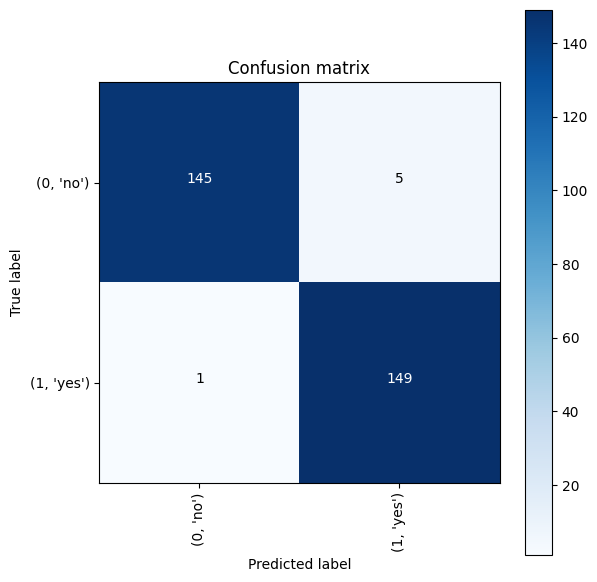

In [28]:
# Validate on validation set
predictions_val = model.predict(X_val_prep)
predictions_val = [1 if x > 0.5 else 0 for x in predictions_val]

# Calculate accuracy
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation Accuracy = %.2f' % accuracy_val)

# Compute confusion matrix
confusion_mtx_val = confusion_matrix(y_val, predictions_val)

# Plot confusion matrix
cm_val = plot_confusion_matrix(confusion_mtx_val, classes=list(labels.items()), normalize=False)

In [29]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

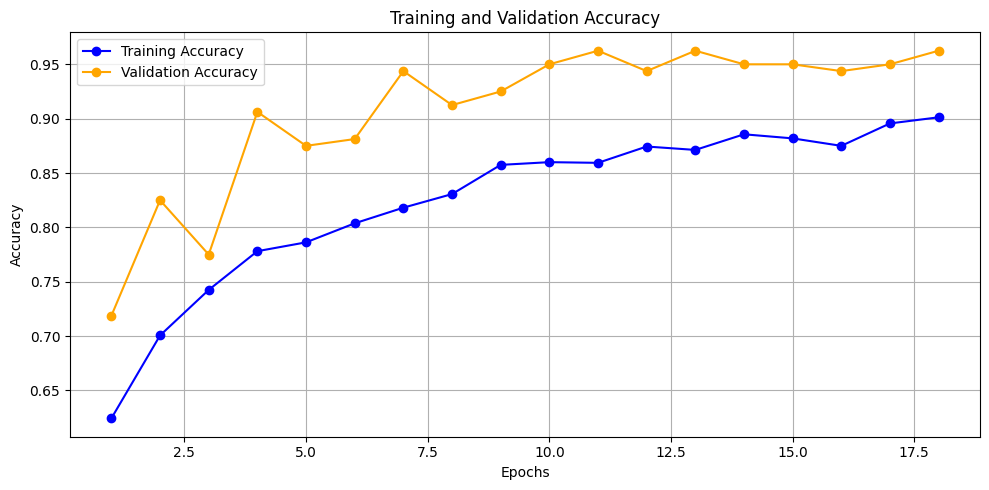

In [30]:
# Plot accuracy
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o', color='blue')

# Plot validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', color='orange')

# Title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("assets/training_validation_accuracy.png")

# Show the plot
plt.show()


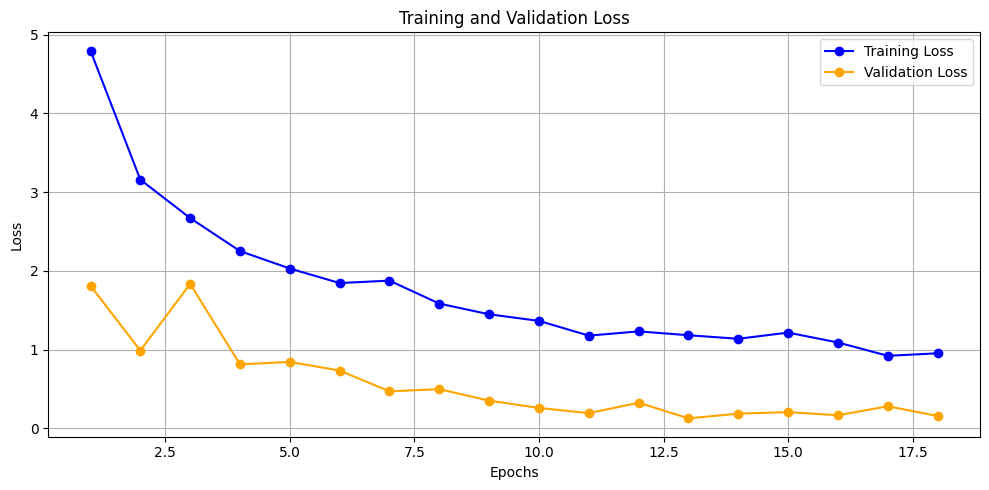

In [31]:
# Plot loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='blue')

# Plot validation loss
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='orange')

# Title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("assets/training_validation_loss.png")

# Show the plot
plt.show()


10/10 [==============================] - 18s 2s/step
Test Accuracy = 0.96


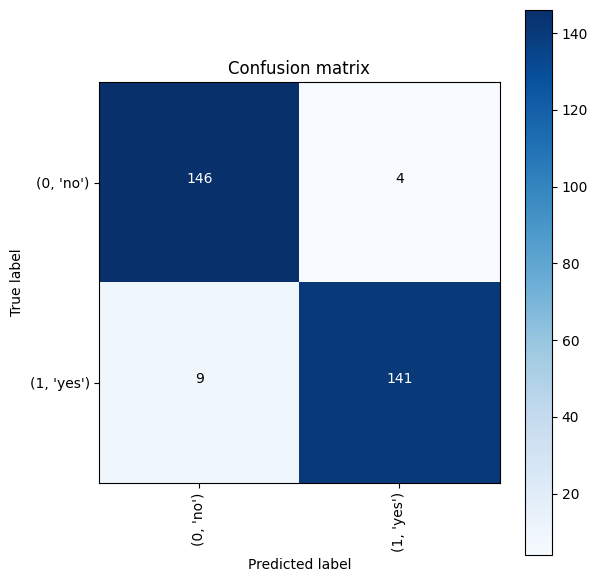

In [32]:
# Validate on test set
predictions_test = model.predict(X_test_prep)
predictions_test = [1 if x > 0.5 else 0 for x in predictions_test]

# Calculate accuracy
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test Accuracy = %.2f' % accuracy_test)

# Compute confusion matrix
confusion_mtx_test = confusion_matrix(y_test, predictions_test)

# Plot confusion matrix
cm_test = plot_confusion_matrix(confusion_mtx_test, classes=list(labels.items()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

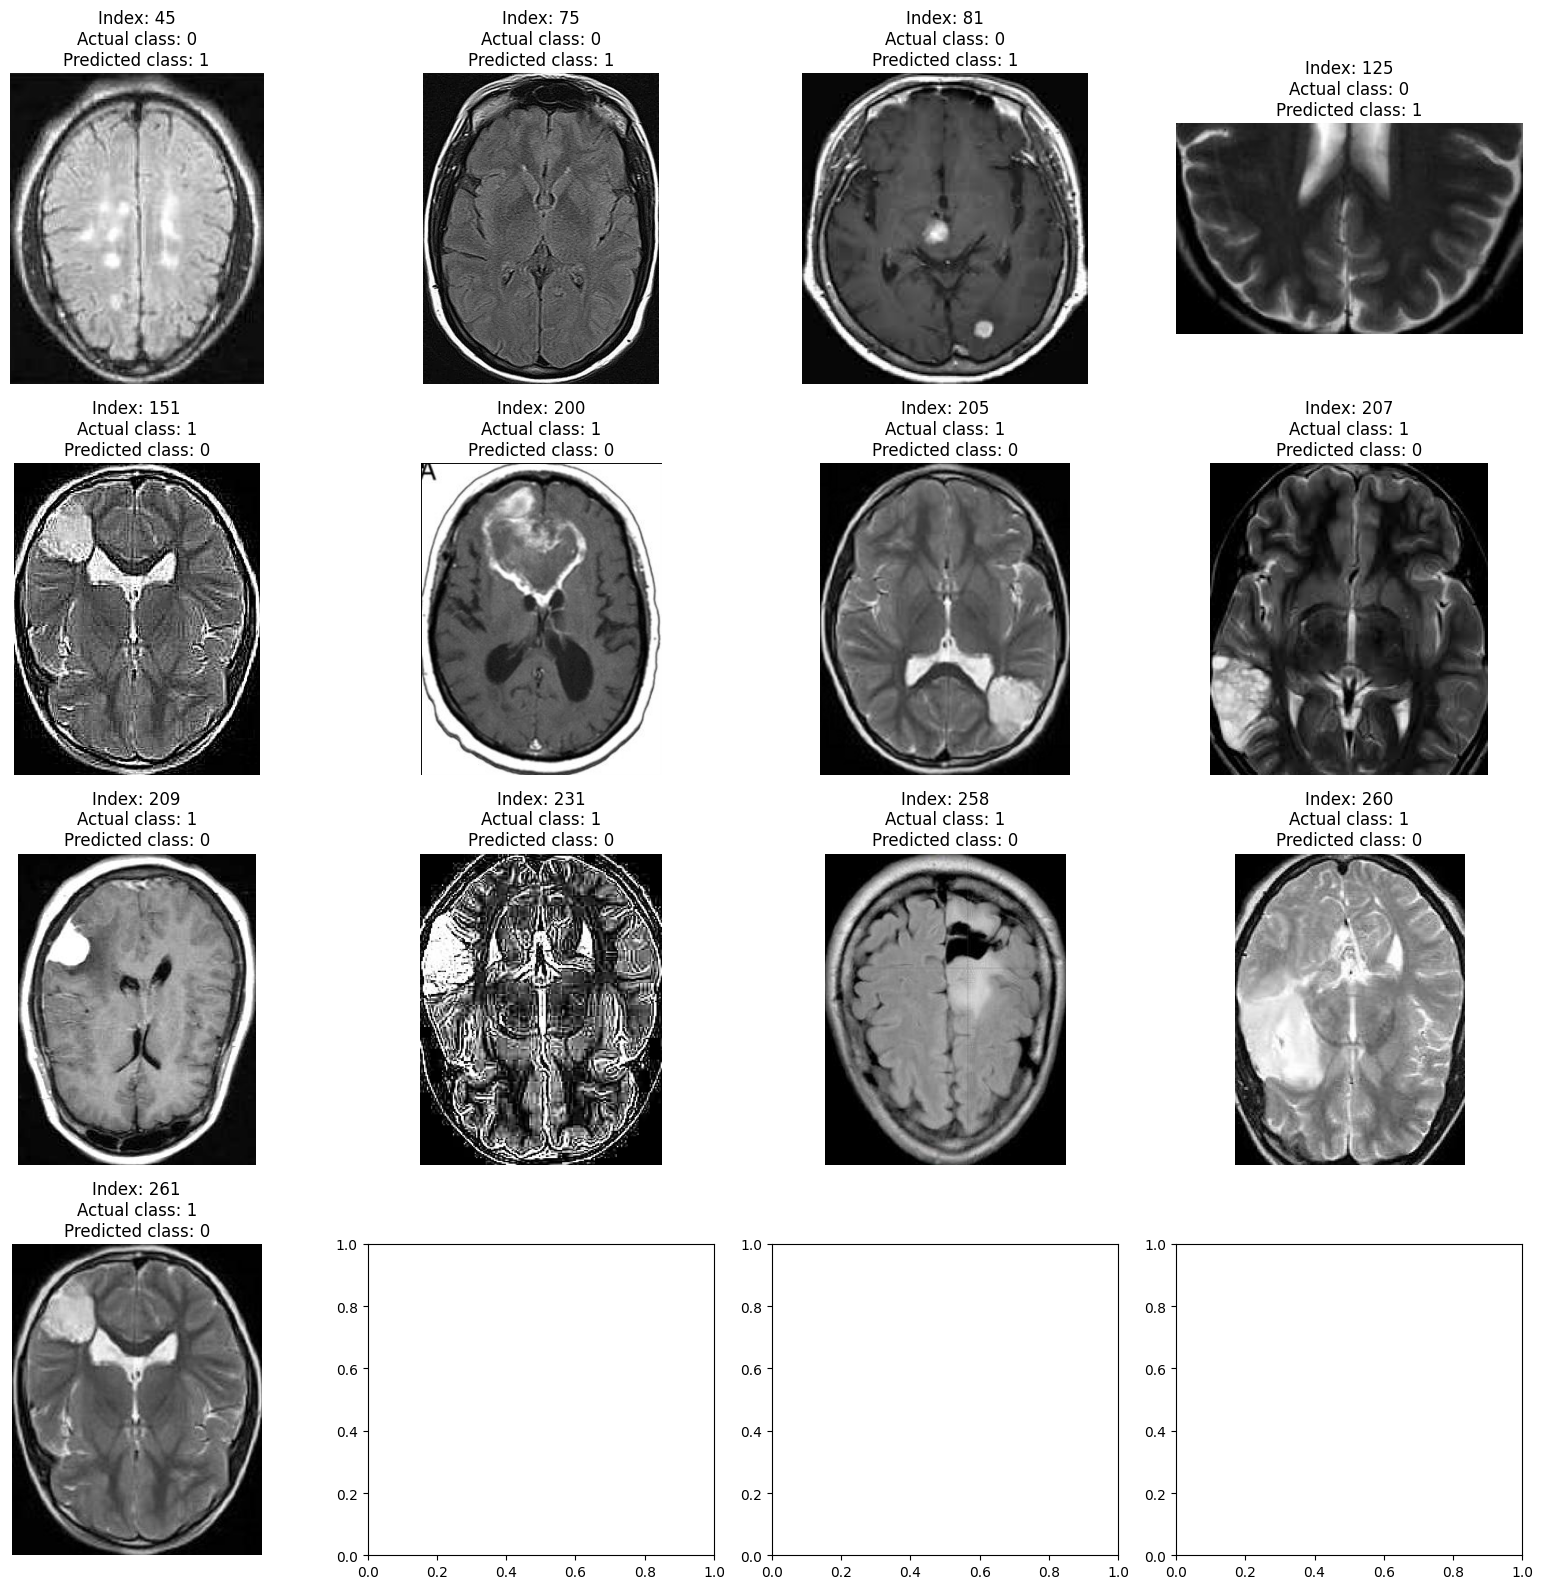

In [33]:
# Find indices of misclassified images
ind_list = np.argwhere((y_test == predictions_test) == False)[:, -1]

# Check if there are misclassified images
if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    # Calculate the number of misclassified images and determine the number of rows for the grid
    num_images = ind_list.size
    num_rows = (num_images + 3) // 4  # Adjust the number of images per row as needed

    # Create a figure and subplots for visualization
    fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))

    # Iterate over misclassified image indices
    for i, idx in enumerate(ind_list):
        row = i // 4  # Calculate the row index
        col = i % 4   # Calculate the column index
        axs[row, col].imshow(X_test_crop[idx])  # Display the misclassified image
        axs[row, col].set_title(f'Index: {idx}\nActual class: {y_test[idx]}\nPredicted class: {predictions_test[idx]}')
        axs[row, col].axis('off')  # Turn off axis labels for better visualization

    plt.tight_layout()  # Adjust layout to prevent overlap

    # Save the plot as a PNG file
    plt.savefig("assets/misclassified_images.png")

    # Show the plot
    plt.show()


# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

In [34]:
# save the model
model.save('brain_tumor_detection_vgg-16_model.h5')

In [35]:
# save the model
model.save('brain_tumor_detection_vgg-16_model.keras')